# Food Classification Using Convolutional Neural Networks (CNNs)

This notebook implements a Convolutional Neural Network (CNN) for the classification of food images into predefined grades. The model leverages RGB image data and predicts the grade of dishes based on their visual features, addressing a multi-class classification problem.

## Dataset Overview
- **Image Type:** Overhead RGB images of food items presented on white plates.
- **Classes:** Each image is labeled with a specific grade, representing the target variable.
- **Preprocessing:** 
  - Images are resized to `(IMG_HEIGHT, IMG_WIDTH)` to standardize input dimensions and optimize computational efficiency.
  - Pixel values are normalized to a range of [0, 1].
  - Data augmentation techniques such as random rotation, flipping, and zooming are applied to improve model robustness.
- **Labels:** Labels are one-hot encoded to facilitate multi-class classification using categorical cross-entropy as the loss function.

## Objectives
1. **Data Preprocessing and Augmentation:** 
   - Normalize and augment the dataset to improve model performance.
   - Dynamically generate batches to handle the dataset efficiently.
2. **Model Implementation:**
   - Define a CNN with the following architecture:
     - **Input Layer:** Accepts images of dimensions `(IMG_HEIGHT, IMG_WIDTH, 3)`.
     - **Convolutional Layers:**
       - **First Layer:** 8 filters with kernel size `(4, 4)`, ReLU activation, and "same" padding, followed by `MaxPool2D()`.
       - **Second Layer:** 16 filters with kernel size `(3, 3)`, ReLU activation, and "same" padding, followed by another `MaxPool2D()`.
     - **Flatten Layer:** Converts the output of the convolutional layers into a 1D vector.
     - **Fully Connected Layers:**
       - A dense layer with 16 neurons and ReLU activation.
       - A dropout layer with a rate of 0.3 to reduce overfitting.
       - An output layer with `7 Food Grades` neurons and softmax activation for class probabilities.
   - **Optimizer:** RMSprop optimizer with default parameters.
   - **Loss Function:** Categorical cross-entropy.
3. **Model Evaluation:**
   - Analyze model accuracy and loss on training and validation datasets.
   - Visualize training history to assess convergence and detect overfitting or underfitting.
4. **Visualization and Insights:**
   - Display performance metrics such as accuracy and a confusion matrix.
   - Visualize misclassified samples to understand model limitations.

## Challenges and Design Choices
- **Limited Dataset Size:** Due to a small dataset, data augmentation and dropout were critical for regularization.
- **Custom Architecture:** A lightweight CNN architecture was designed to balance complexity and performance given the dataset constraints.
- **Data Pipeline:** A dynamic data loader was implemented to preprocess and augment data efficiently during training.


## Importing Libraries
We import the necessary libraries for data processing, model training, and evaluation.

In [2]:
import os
import glob
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

## Paths and Settings
We set paths for training and testing data and define important parameters such as image dimensions and batch size.

In [3]:
# Paths and settings
os.chdir("C:/Users/abhij/OneDrive/Bentley/Bentley University/Fall 2024/MA 707 Machine Learning/Group project")
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Reduced resolution for computational efficiency
batch_size = 70
train_folder = "C:/Users/abhij/OneDrive/Bentley/Bentley University/Fall 2024/MA 707 Machine Learning/Group project/train"
test_folder = "C:/Users/abhij/OneDrive/Bentley/Bentley University/Fall 2024/MA 707 Machine Learning/Group project/test"

## Load and Preprocess Data
We begin by loading the dataset (`dishes_with_grade.csv`) into a pandas DataFrame. The grades are encoded as integers, and one-hot encoding is applied for multi-class classification. 
Class weights are also calculated to address class imbalances.

In [4]:
# Load and preprocess the new CSV file (dishes_with_grade.csv)
df = pd.read_csv('dishes_with_grade.csv')

# Encode Grade as integers, then one-hot encode
le = LabelEncoder()
df['Grade'] = le.fit_transform(df['Grade'])
grades = to_categorical(df['Grade'])
dish_labels = {str(row['dish_ID']): grades[idx] for idx, row in df.iterrows()}

# Calculate class weights
class_frequencies = np.array([1041, 661, 499, 383, 607, 19, 52])  # Example frequencies, replace with your actual counts
total_samples = np.sum(class_frequencies)
inverse_frequencies = total_samples / class_frequencies
normalized_class_weights = inverse_frequencies / np.sum(inverse_frequencies)  # Normalize weights

## Define Custom Image Generator
The custom image generator loads images from specified directories, processes them, and provides batches of images and labels for training and testing.

In [5]:
# Custom generator to load images and labels
def custom_image_generator(folder_path, labels_dict, img_height, img_width, batch_size):
    """
    Generator for loading images from a folder and corresponding labels in batches.
    
    Args:
        folder_path (str): Path to the folder containing subfolders with images.
        labels_dict (dict): Dictionary mapping dish_ID to labels.
        img_height (int): Height of resized images.
        img_width (int): Width of resized images.
        batch_size (int): Number of samples per batch.
    
    Yields:
        images, batch_labels: Arrays of images and corresponding labels.
    """
    subfolders = sorted(os.listdir(folder_path))  # Ensure consistent order
    while True:
        images = []
        batch_labels = []
        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            image_files = glob.glob(os.path.join(subfolder_path, "*.jpg"))
            if not image_files:
                continue

            # Randomly sample images from the directory
            for img_path in image_files:
                img = plt.imread(img_path)
                img = np.resize(img, (img_height, img_width, 3))
                images.append(img)

                # Append corresponding label
                batch_labels.append(labels_dict[subfolder])

                # Break if batch size is met
                if len(images) == batch_size:
                    break
            if len(images) == batch_size:
                break

        # Convert to numpy arrays
        images = np.array(images, dtype="float32") / 255.0
        batch_labels = np.array(batch_labels, dtype="float32")
        yield images, batch_labels

## Prepare Data Generators
Set up data generators for training and testing using the custom image generator. Ensure the folder paths and batch size match the dataset structure.

In [6]:
# Training and testing data generators
train_generator = custom_image_generator(
    train_folder, dish_labels, IMG_HEIGHT, IMG_WIDTH, batch_size
)
test_generator = custom_image_generator(
    test_folder, dish_labels, IMG_HEIGHT, IMG_WIDTH, batch_size
)

## Define and Compile CNN Model
Build the CNN model with convolutional, pooling, and dense layers. Use softmax activation in the output layer for multi-class classification.

In [7]:
# Define CNN model
num_classes = len(df['Grade'].unique())  

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(8, kernel_size=(4, 4), activation='relu', padding='same'),
    MaxPool2D(),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model with normalized class weights
model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(),  
    metrics=["accuracy"]
)

## Train the Model
Fit the model using training and testing data generators. Early stopping is applied to avoid overfitting.

In [8]:
# Early stopping
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    restore_best_weights=True
)

# Train the model
total_train_images = sum(len(glob.glob(os.path.join(train_folder, subfolder, "*.jpg"))) for subfolder in os.listdir(train_folder))
total_test_images = sum(len(glob.glob(os.path.join(test_folder, subfolder, "*.jpg"))) for subfolder in os.listdir(test_folder))

steps_per_epoch = total_train_images // batch_size
validation_steps = total_test_images // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 112s 271ms/step - accuracy: 0.7671 - loss: 0.6137 - val_accuracy: 0.3714 - val_loss: 2.9652
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 103s 253ms/step - accuracy: 0.9378 - loss: 0.1558 - val_accuracy: 0.3714 - val_loss: 3.4860
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 101s 248ms/step - accuracy: 0.9431 - loss: 0.1345 - val_accuracy: 0.3714 - val_loss: 3.2702


## Evaluate the Model
Evaluate the model's performance on the test dataset and save predictions for further analysis.

In [9]:
# Evaluate the model
results = []
for i, (images, labels) in enumerate(test_generator):
    if i >= validation_steps:  # Limit to the number of validation steps
        break
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(labels, axis=1)
    for pred, actual in zip(predicted_classes, actual_classes):
        results.append({
            "Predicted Grade": le.inverse_transform([pred])[0],
            "Actual Grade": le.inverse_transform([actual])[0]
        })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('classification_results.csv', index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## Visualize Results
Plot training and validation loss and accuracy to assess model performance over epochs.

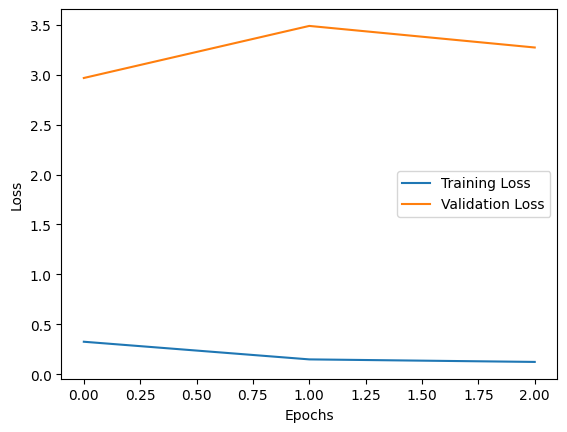

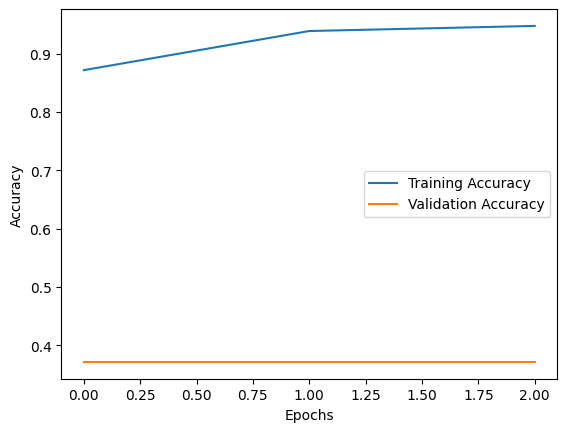

In [10]:
# Plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predict Grade for Unseen Food Items
This section loads images from a specified directory containing unseen food items, preprocesses them to match the model's input format, and predicts the grades using the trained CNN model. The predictions are displayed along with optional visualizations.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: Avocado.jpg - Predicted Grade: C
Image: Pasta.jpg - Predicted Grade: C
Image: Turkey-Fruit-Plate.jpg - Predicted Grade: C
Image: Unhealthy Food.jpg - Predicted Grade: C


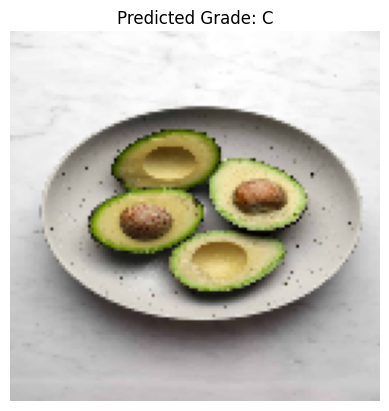

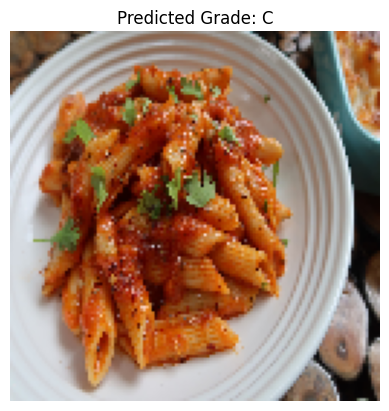

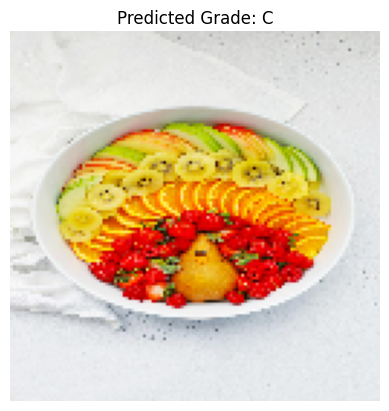

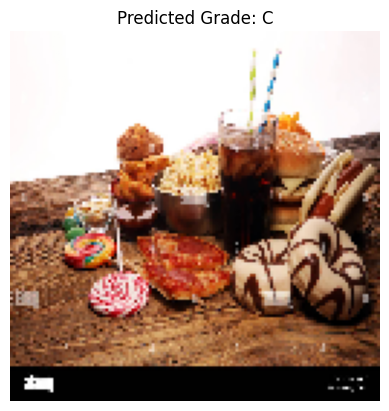

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the unseen directory
unseen_folder = "C:/Users/abhij/OneDrive/Bentley/Bentley University/Fall 2024/MA 707 Machine Learning/Group project/Unseen"

# Function to load and preprocess images
def load_and_preprocess_images(folder_path, img_height, img_width):
    images = []
    image_files = []
    for img_file in glob.glob(os.path.join(folder_path, "*.jpg")):
        img = load_img(img_file, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize the image
        images.append(img_array)
        image_files.append(img_file)
    return np.array(images), image_files

# Load and preprocess unseen images
unseen_images, image_files = load_and_preprocess_images(unseen_folder, IMG_HEIGHT, IMG_WIDTH)

# Predict using the trained model
if unseen_images.size > 0:  # Check if there are images in the folder
    predictions = model.predict(unseen_images)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_grades = le.inverse_transform(predicted_classes)

    # Display predictions
    for img_file, pred_grade in zip(image_files, predicted_grades):
        print(f"Image: {os.path.basename(img_file)} - Predicted Grade: {pred_grade}")
        
    # Optionally visualize predictions
    for img, pred_grade in zip(unseen_images, predicted_grades):
        plt.imshow(img)
        plt.title(f"Predicted Grade: {pred_grade}")
        plt.axis('off')
        plt.show()
else:
    print("No images found in the 'Unseen' directory.")